In [1]:
import pandas as pd
import numpy as np
from federated_learning.coordinator import FederatedLearning
from federated_learning.models.logistic_v2 import LogisticModel_Stat

In [2]:
def run_federated_learning(
    file_paths,
    features=['DriverAge', 'Gender', 'VehiculeUsage'],
    target='Sinistre',
    num_rounds=1,
    normalize_age=True,
    visualize=True
):
    """
    Exécute l'apprentissage fédéré sur les données fournies.
    """
    try:
        data_dict = {}
        for client_name, path in file_paths.items():
            df = pd.read_csv(path)
            print(f"Données chargées pour {client_name}: {len(df)} lignes")
            data_dict[client_name] = df

        # Normalisation (optionnelle)
        if normalize_age:
            for client_name, df in data_dict.items():
                if 'DriverAge' in df.columns:
                    print(f"Normalisation de DriverAge pour {client_name}")
                    df['DriverAge'] = (df['DriverAge'] - df['DriverAge'].mean()) / df['DriverAge'].std()

        # Initialisation du système fédéré
        print("\nConfiguration du système d'apprentissage fédéré...")
        fl = FederatedLearning(
            data_dict=data_dict,
            features=features,
            target=target,
            model_class=LogisticModel_Stat
        )
        fl.setup()

        # Entraînement
        print("\nDémarrage de l'entraînement fédéré...")
        global_weights = fl.train(num_rounds=num_rounds)
        feature_names = ['Intercept'] + features

        print("\nApprentissage fédéré terminé.")
        print("\nPoids globaux finaux :")
        for name, weight in zip(feature_names, global_weights):
            print(f"  {name}: {weight:.6f}")

        # Tentative d'accès aux p-valeurs si possible
        p_values = {}
        first_model = fl.server.clients[0].model
        if hasattr(first_model, 'results') and hasattr(first_model.results, 'pvalues'):
            print("\nP-valeurs estimées :")
            for i, name in enumerate(feature_names):
                val = first_model.results.pvalues.iloc[i]
                p_values[name] = val
                print(f"  {name}: {val:.6f}")
        else:
            print("\nP-valeurs indisponibles pour le modèle actuel.")

        # Récupération des poids locaux
        clients_weights = {
            client.name: client.model.get_weights()
            for client in fl.server.clients
            if hasattr(client.model, 'get_weights')
        }

        if visualize:
            fl.visualize_diagnostics()
            fl.plot_model_coefficients()

        return global_weights, clients_weights, feature_names, p_values

    except Exception as e:
        print(f"[Erreur] exécution interrompue : {e}")
        import traceback
        traceback.print_exc()
        return None, None, None, None


Données chargées pour Client Fr: 243065 lignes
Données chargées pour Client BE: 163212 lignes
Données chargées pour Client EU: 237319 lignes
Normalisation de DriverAge pour Client Fr
Normalisation de DriverAge pour Client BE
Normalisation de DriverAge pour Client EU

Configuration du système d'apprentissage fédéré...
Configuration du client 'Client Fr' avec 243065 observations
Client 'Client Fr' ajouté avec succès
Configuration du client 'Client BE' avec 163212 observations
Client 'Client BE' ajouté avec succès
Configuration du client 'Client EU' avec 237319 observations
Client 'Client EU' ajouté avec succès

Démarrage de l'entraînement fédéré...

Démarrage de l'entraînement fédéré (1 cycle(s))...

Démarrage de l'apprentissage fédéré avec 3 clients

Poids du modèle local pour Client Fr:
  Intercept: -1.682113
  DriverAge: -0.089316
  Gender: 0.002589
  VehiculeUsage: -0.162792
[DEBUG] Prédictions positives : 48533 / 48613
[DEBUG] Répartition y_test : [45460  3153]
Performance du modèle

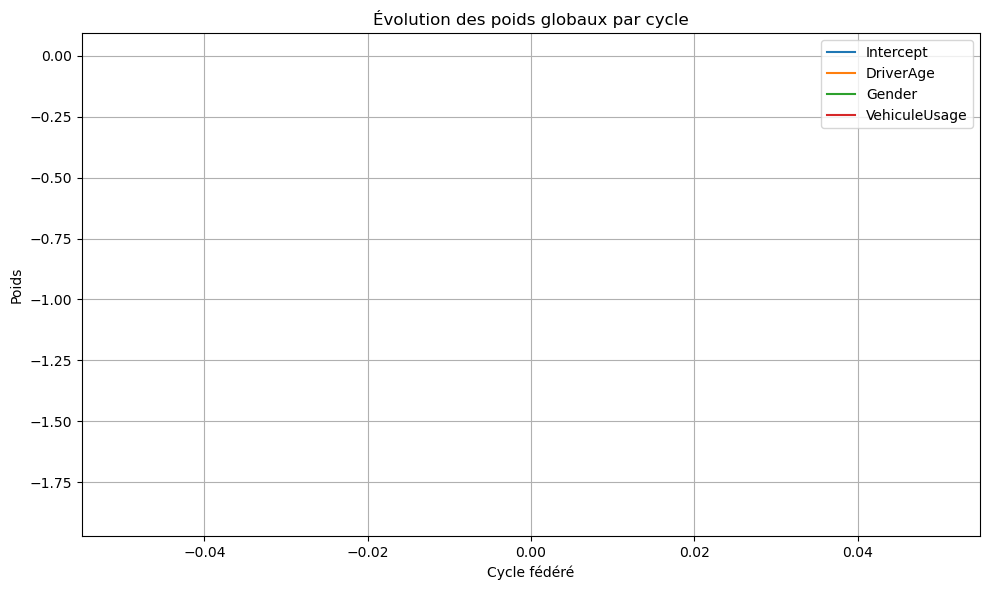

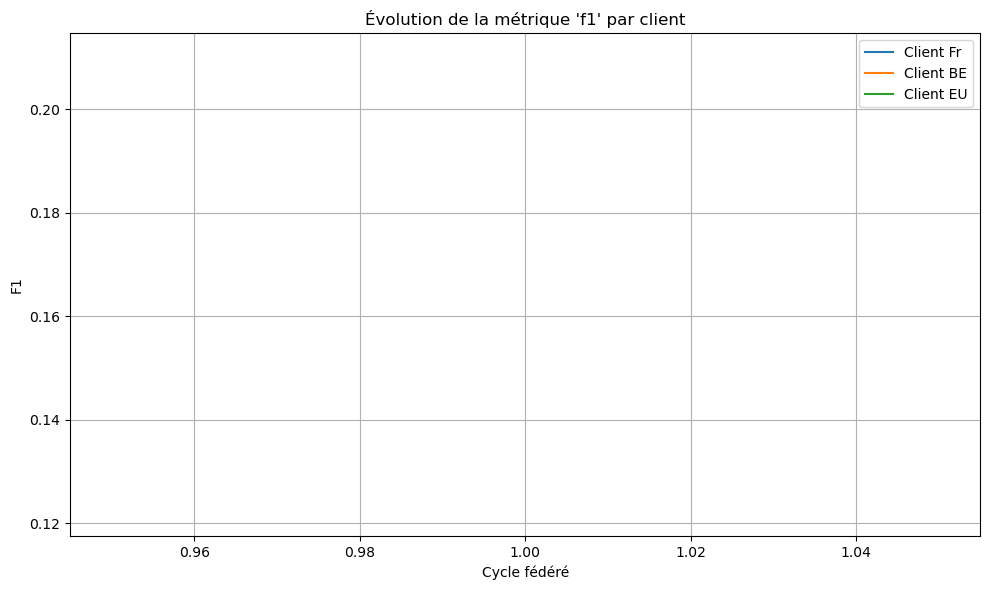


Distribution des classes cibles par client :

Client Fr :
  Classe 0 : 227162 exemples
  Classe 1 : 15903 exemples

Client BE :
  Classe 0 : 144936 exemples
  Classe 1 : 18276 exemples

Client EU :
  Classe 0 : 219096 exemples
  Classe 1 : 18223 exemples

Distribution des probabilités prédites par client :


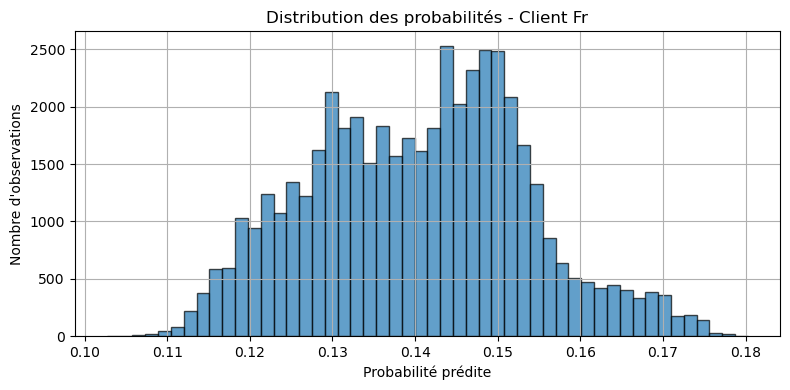

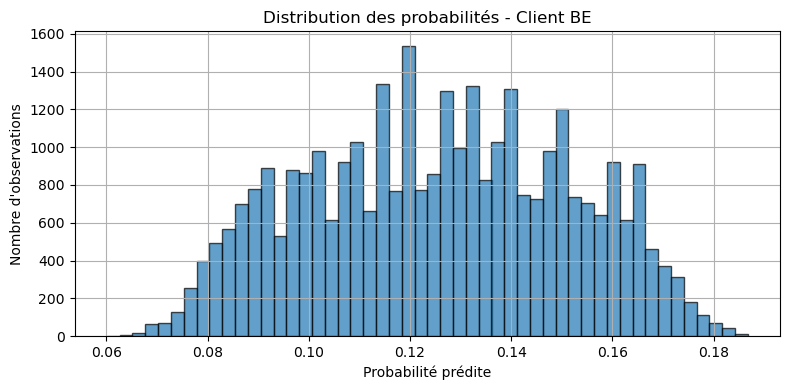

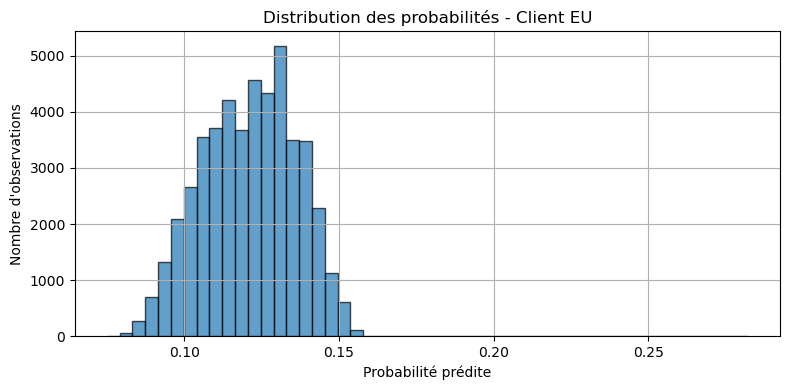


Courbes ROC par client :


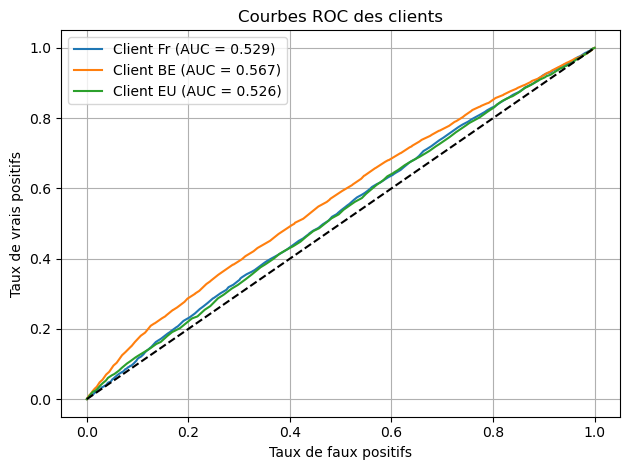


Courbes Precision-Recall par client :


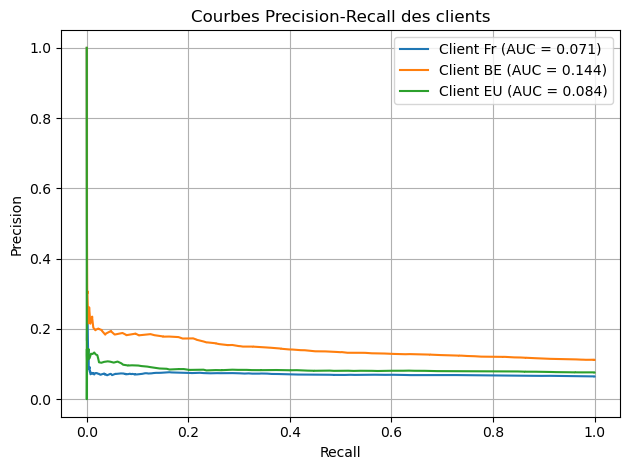


Test statistique des coefficients du premier client :
Intercept      : coef = -1.6821, p = 0, SE = 0.0214, 95% CI = [-1.7240, -1.6402]
DriverAge      : coef = -0.0893, p = 7.281e-21, SE = 0.0095, 95% CI = [-0.1080, -0.0706]
Gender         : coef = 0.0026, p = 0.8942, SE = 0.0195, 95% CI = [-0.0356, 0.0407]
VehiculeUsage  : coef = -0.1628, p = 3.528e-12, SE = 0.0234, 95% CI = [-0.2087, -0.1169]


/Users/nayelbenabdesadok/GitProjects/Federated_Learning_Milliman/federated_learning/coordinator.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = res.params[i]
/Users/nayelbenabdesadok/GitProjects/Federated_Learning_Milliman/federated_learning/coordinator.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pval = res.pvalues[i]
/Users/nayelbenabdesadok/GitProjects/Federated_Learning_Milliman/federated_learning/coordinator.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior).

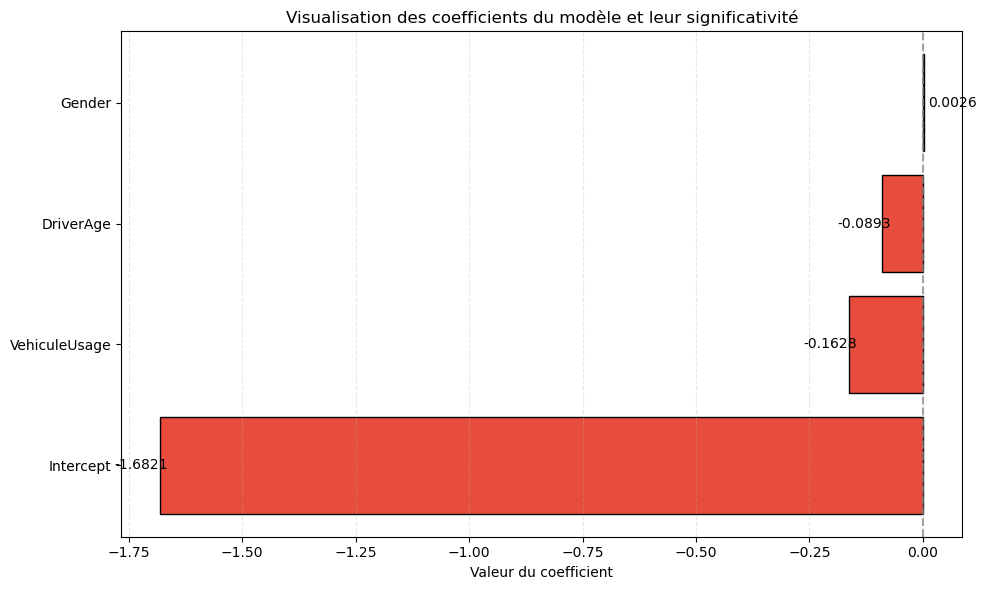

(array([-1.87732607, -0.14897688, -0.00217365, -0.04962186]),
 {'Client Fr': array([-1.68211272, -0.08931625,  0.00258926, -0.16279163]),
  'Client BE': array([-1.95233665, -0.24114795,  0.02679463, -0.01704601]),
  'Client EU': array([-2.02567912, -0.14669326, -0.02697422,  0.04388472])},
 ['Intercept', 'DriverAge', 'Gender', 'VehiculeUsage'],
 {'Intercept': np.float64(0.0),
  'DriverAge': np.float64(7.281448781625936e-21),
  'Gender': np.float64(0.8941926781650457),
  'VehiculeUsage': np.float64(3.5283312799137353e-12)})

In [3]:
file_paths = {
    'Client Fr': 'data/french_data.csv',
    'Client BE': 'data/belgium_data.csv',
    'Client EU': 'data/european_data.csv'
}

run_federated_learning(file_paths)